In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define Pauli matrices and identity.
sigma0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma1 = np.array([[0, 1], [1, 0]], dtype=complex)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma3 = np.array([[1, 0], [0, -1]], dtype=complex)

In [3]:
# Define Gamma matrices: Gamma_{ij} = sigma_i ⊗ sigma_j.
Gamma_13 = np.kron(sigma1, sigma3)
Gamma_30 = np.kron(sigma3, sigma0)
Gamma_03 = np.kron(sigma0, sigma3)
Gamma_12 = np.kron(sigma1, sigma2)
Gamma_31 = np.kron(sigma3, sigma1)
Gamma_21 = np.kron(sigma2, sigma1)
Gamma_32 = np.kron(sigma3, sigma2)

In [4]:
def h_k(kx, ky, alpha, beta, delta):
    """
    Constructs the 4x4 Bloch Hamiltonian h(k) at (kx, ky)
    for the given parameters.
    """
    term1 = 0.5 * Gamma_13
    term2 = (alpha/2.0) * (np.cos(kx) + np.cos(ky)) * (Gamma_30 + Gamma_03)
    term3 = (Gamma_12 + Gamma_31) * np.sin(kx)
    term4 = (Gamma_21 + Gamma_32) * np.sin(ky)
    term5 = - Gamma_03
    term6 = (beta/2.0) * np.cos(kx) * (np.cos(ky) - delta) * (Gamma_03 - Gamma_30)
    H = term1 + term2 + term3 + term4 + term5 + term6
    return H

In [5]:
def compute_inversion_representations(alpha, beta, delta):
    """
    Computes the inversion symmetry representations for the two occupied bands 
    (lowest two eigenstates) at the four high-symmetry (TRIM) points:
      Gamma = (0,0), X = (pi, 0), Y = (0, pi), M = (pi, pi).
    Returns a dictionary mapping each TRIM label to a list of parity eigenvalues (+1 or -1).
    """
    # Inversion operator
    P = Gamma_03  # sigma0 ⊗ sigma3

    # Define TRIM points.
    trim_points = {
        'Gamma': (0, 0),
        'X': (np.pi, 0),
        'Y': (0, np.pi),
        'M': (np.pi, np.pi)
    }
    
    results = {}
    for label, (kx, ky) in trim_points.items():
        H = h_k(kx, ky, alpha, beta, delta)
        # Diagonalize: np.linalg.eigh returns eigenvalues in ascending order.
        eigvals, eigvecs = np.linalg.eigh(H)
        # Select the two lowest (occupied) eigenstates.
        occ_states = eigvecs[:, :2]
        parities = []
        for i in range(occ_states.shape[1]):
            psi = occ_states[:, i]
            # Expectation value <psi|P|psi> should be ±1.
            parity_val = np.vdot(psi, P @ psi).real
            # Round to ±1 if close.
            if np.abs(np.abs(parity_val) - 1) < 1e-6:
                parity_val = np.sign(parity_val)
            parities.append(int(parity_val))
        results[label] = parities
    return results

In [6]:
def compute_wilson_loop_fixed_ky(ky, alpha, beta, delta, Nk=100):
    """
    Computes the Wilson loop along kx for a fixed ky.
    Discretizes kx over the Brillouin zone (here taken as from -pi to pi)
    and computes the overlap matrices between occupied eigenstates (the lowest two bands).
    Returns the eigenphases (angles) of the Wilson loop operator.
    """
    kx_vals = np.linspace(-np.pi, np.pi, Nk, endpoint=False)
    occ_states = []
    
    # Compute occupied eigenstates at each kx.
    for kx in kx_vals:
        H = h_k(kx, ky, alpha, beta, delta)
        eigvals, eigvecs = np.linalg.eigh(H)
        # Choose the two lowest eigenstates.
        occ_states.append(eigvecs[:, :2])
        
    # Initialize Wilson loop as the identity in the occupied subspace.
    W = np.eye(2, dtype=complex)
    # Loop over discretized kx points.
    for i in range(Nk):
        U_current = occ_states[i]
        U_next = occ_states[(i + 1) % Nk]  # periodic boundary conditions.
        # Overlap matrix: F = U_current^dagger U_next.
        F = np.conjugate(U_current).T @ U_next
        # Project F to the nearest unitary using singular value decomposition.
        U, s, Vh = np.linalg.svd(F)
        F_unitary = U @ Vh
        W = F_unitary @ W  # accumulate product (path ordering)
    
    # Diagonalize the Wilson loop operator.
    wilson_eigs, _ = np.linalg.eig(W)
    # Extract the phases (angles) of the eigenvalues.
    phases = np.angle(wilson_eigs)
    phases = np.sort(phases)
    return phases

In [7]:
def plot_wannier_centers_vs_ky(alpha, beta, delta, Nk_kx=100, Nk_ky=50):
    """
    Computes the Wilson loop along kx for each ky in the interval [-pi, pi)
    and plots the Wannier centers (Wilson loop eigenphases) versus ky.
    One can read off the winding of these centers to deduce the Chern number.
    """
    ky_vals = np.linspace(-np.pi, np.pi, Nk_ky, endpoint=False)
    wannier_data = []  # list of pairs of eigenphases for each ky
    
    for ky in ky_vals:
        phases = compute_wilson_loop_fixed_ky(ky, alpha, beta, delta, Nk=Nk_kx)
        # For clarity, you might want to bring phases to [0, 2pi) or rescale (e.g., to [0,1])
        # Here we simply plot the phases.
        wannier_data.append(phases)
    
    wannier_data = np.array(wannier_data)  # shape (Nk_ky, 2)
    
    # Plotting
    plt.figure(figsize=(8,5))
    for band in range(wannier_data.shape[1]):
        plt.plot(ky_vals, wannier_data[:, band], 'o-', label=f'Band {band+1}')
    
    plt.xlabel('$k_y$')
    plt.ylabel('Wannier center (eigenphase)')
    plt.title(f'Wannier centers vs. $k_y$ for (alpha, beta, delta)=({alpha}, {beta}, {delta})')
    plt.legend()
    plt.grid(True)
    plt.show()

Inversion representations for (-1.5, 0, 0):
  Gamma: [1, 1]
  X: [1, 1]
  Y: [1, 1]
  M: [-1, 1]

Wilson loop eigenphases for ky=0:
[-0.02583863  0.02583863]
Wilson loop eigenphases for ky=pi:
[0.12699424 3.01459841]


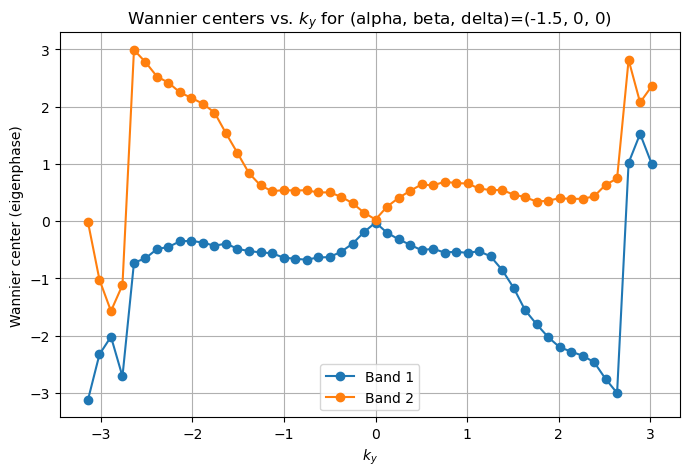

In [15]:
# Parameter set 1: (-1.5, 0, 0)
params1 = (-1.5, 0, 0)
print("Inversion representations for (-1.5, 0, 0):")
reps1 = compute_inversion_representations(*params1)
for kpoint, parity in reps1.items():
    print(f"  {kpoint}: {parity}")

# Wilson loop at ky=0 and ky=pi for params1.
print("\nWilson loop eigenphases for ky=0:")
phases_ky0 = compute_wilson_loop_fixed_ky(0, *params1)
print(phases_ky0)

print("Wilson loop eigenphases for ky=pi:")
phases_kypi = compute_wilson_loop_fixed_ky(np.pi, *params1)
print(phases_kypi)

# Plot Wannier centers vs. ky.
plot_wannier_centers_vs_ky(*params1)



Inversion representations for (-1.5, 1.5, -1):
  Gamma: [1, -1]
  X: [1, 1]
  Y: [1, 1]
  M: [-1, 1]

Wilson loop eigenphases for ky=0:
[0.0198636  3.12172905]
Wilson loop eigenphases for ky=pi:
[0.12699424 3.01459841]


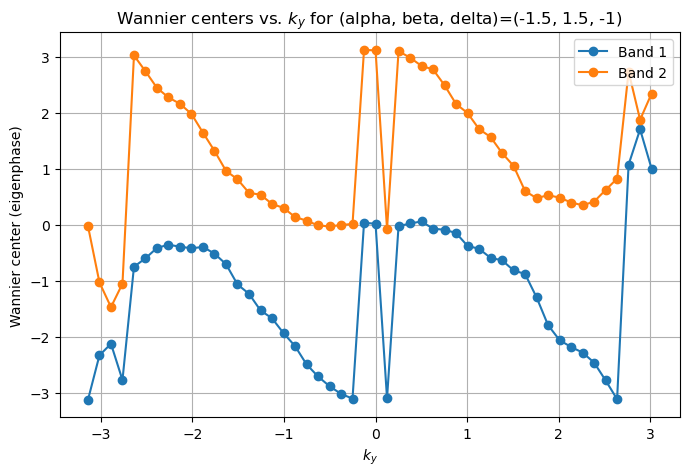

In [16]:
# Parameter set 2: (-1.5, 1.5, -1)
params2 = (-1.5, 1.5, -1)
print("\nInversion representations for (-1.5, 1.5, -1):")
reps2 = compute_inversion_representations(*params2)
for kpoint, parity in reps2.items():
    print(f"  {kpoint}: {parity}")

print("\nWilson loop eigenphases for ky=0:")
phases2_ky0 = compute_wilson_loop_fixed_ky(0, *params2)
print(phases2_ky0)

print("Wilson loop eigenphases for ky=pi:")
phases2_kypi = compute_wilson_loop_fixed_ky(np.pi, *params2)
print(phases2_kypi)

plot_wannier_centers_vs_ky(*params2)


In [17]:
import numpy as np
from scipy.linalg import eigh

# Pauli matrices
sigma = np.array([
    [[1, 0], [0, 1]],          # sigma_0
    [[0, 1], [1, 0]],          # sigma_1
    [[0, -1j], [1j, 0]],       # sigma_2
    [[1, 0], [0, -1]]          # sigma_3
], dtype=complex)

def gamma_matrix(i, j):
    """Construct Gamma_{ij} = sigma_i ⊗ sigma_j."""
    return np.kron(sigma[i], sigma[j])

def hamiltonian(kx, ky, alpha, beta, delta):
    """Construct the Bloch Hamiltonian h(k)."""
    # Term 1: (1/2)Γ₁₃
    term1 = 0.5 * gamma_matrix(1, 3)
    
    # Term 2: (α/2)(coskx + cosky)(Γ₃₀ + Γ₀₃)
    coskx, cosky = np.cos(kx), np.cos(ky)
    term2 = 0.5 * alpha * (coskx + cosky) * (gamma_matrix(3, 0) + gamma_matrix(0, 3))
    
    # Term 3: (Γ₁₂ + Γ₃₁)sinkx
    sinkx = np.sin(kx)
    term3 = sinkx * (gamma_matrix(1, 2) + gamma_matrix(3, 1))
    
    # Term 4: (Γ₂₁ + Γ₃₂)sinky
    sinky = np.sin(ky)
    term4 = sinky * (gamma_matrix(2, 1) + gamma_matrix(3, 2))
    
    # Term 5: -Γ₀₃
    term5 = -gamma_matrix(0, 3)
    
    # Term 6: (β/2)coskx(cosky - δ)(Γ₀₃ - Γ₃₀)
    term6 = 0.5 * beta * coskx * (cosky - delta) * (gamma_matrix(0, 3) - gamma_matrix(3, 0))
    
    H = term1 + term2 + term3 + term4 + term5 + term6
    return H

def inversion_representations(alpha, beta, delta):
    """Compute parity eigenvalues at high-symmetry points."""
    k_points = {
        'Γ': (0, 0),
        'X': (np.pi, 0),
        'Y': (0, np.pi),
        'M': (np.pi, np.pi)
    }
    parity = {}
    inv_operator = gamma_matrix(0, 3)  # Γ₀₃
    
    for name, (kx, ky) in k_points.items():
        H = hamiltonian(kx, ky, alpha, beta, delta)
        # Diagonalize to get occupied bands (lowest 2 eigenvalues)
        eigvals, eigvecs = eigh(H)
        occupied_states = eigvecs[:, :2]
        
        # Compute parity eigenvalues (diagonal elements of <ψ|Γ₀₃|ψ>)
        parity_vals = np.diag(occupied_states.conj().T @ inv_operator @ occupied_states)
        parity[name] = np.sign(np.real(parity_vals))  # +1 or -1
    return parity

In [18]:
def wilson_loop_eigenvalues(alpha, beta, delta, ky_fixed):
    """Compute Wilson loop eigenvalues for fixed ky."""
    N = 50  # Number of kx points for discretization
    kx_list = np.linspace(0, 2*np.pi, N, endpoint=False)
    wilson_matrix = np.eye(2, dtype=complex)  # Initialize for 2 occupied bands
    
    for i in range(N):
        kx = kx_list[i]
        H = hamiltonian(kx, ky_fixed, alpha, beta, delta)
        eigvals, eigvecs = eigh(H)
        states = eigvecs[:, :2]  # Occupied states
        
        if i > 0:
            # Overlap matrix between current and previous states
            overlap = prev_states.conj().T @ states
            U, _, Vh = np.linalg.svd(overlap)
            wilson_matrix = wilson_matrix @ U @ Vh  # Gauge-invariant product
        
        prev_states = states
    
    # Diagonalize Wilson loop to get eigenvalues
    eigvals = np.linalg.eigvals(wilson_matrix)
    return np.angle(eigvals)  # Phases (Wannier centers)

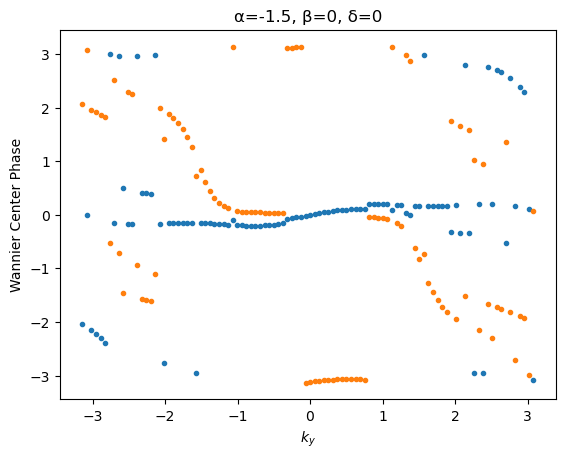

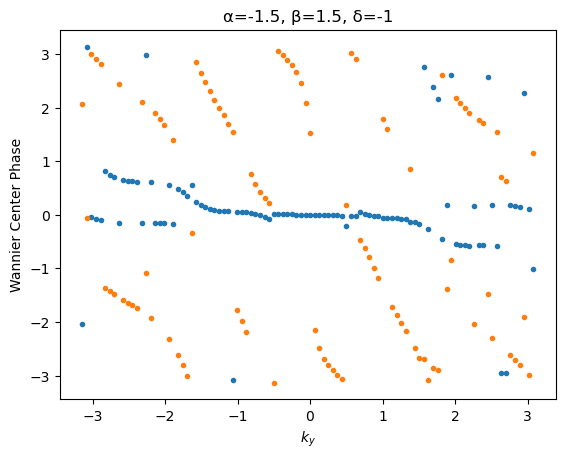

In [19]:
import matplotlib.pyplot as plt

def plot_wannier_centers(alpha, beta, delta):
    """Plot Wannier centers vs ky and compute Chern number."""
    N_ky = 100  # Number of ky points
    ky_list = np.linspace(-np.pi, np.pi, N_ky, endpoint=False)
    wannier_phases = []
    
    for ky in ky_list:
        phases = wilson_loop_eigenvalues(alpha, beta, delta, ky)
        wannier_phases.append(phases)
    
    wannier_phases = np.array(wannier_phases)
    
    # Plot
    plt.figure()
    plt.plot(ky_list, np.real(wannier_phases), '.')
    plt.xlabel(r'$k_y$')
    plt.ylabel('Wannier Center Phase')
    plt.title(f'α={alpha}, β={beta}, δ={delta}')
    plt.show()
    
    # Chern number via winding (count net phase windings)
    chern = np.sum(np.diff(wannier_phases, axis=0) / (2*np.pi))
    return chern

# Example usage:
chern1 = plot_wannier_centers(-1.5, 0, 0)       # Chern ≈ 1
chern2 = plot_wannier_centers(-1.5, 1.5, -1)    # Chern ≈ 0